## Imports

In [1]:
import sys
import os
import numpy as np
import numpy.lib.recfunctions as nprf
from sklearn import linear_model
import matplotlib as mpl
import time

from scipy.stats import gaussian_kde
from importlib import reload
import pandas as pd

mpl.use('Agg')

mpl.rcParams['figure.figsize'] = (7,7)
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
mpl.rcParams.update({'font.size':22})

% matplotlib inline

import matplotlib.pyplot as plt

In [2]:
import tools.matt_tools as matt

reload(matt)

<module 'tools.matt_tools' from '/home/mho1/halo_cnn/notebooks/tools/matt_tools.py'>

In [3]:
from tools.catalog import Cluster, Catalog

In [4]:
wdir = '/home/mho1/scratch/halo_cnn'

# Load Raw Data

In [5]:
data_file = os.path.join(wdir,
                         'data_query',
                         'MDPL2_Rockstar_snap:120_v2_reduced.csv')
dat_MD = pd.read_csv(data_file, index_col=0)
#                          'sfr_catalog_0.671200.npy')
#                         'MDPL2_Rockstar_z=0.117_Macc=1e11.csv')

dat_MD = dat_MD.reset_index(drop=True)

/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
data_file = os.path.join(wdir,
                         'data_raw',
                         'sfr_catalog_0.895100.npy')
dat_UM = np.load(data_file)
dat_UM = pd.DataFrame(dat_UM)


In [7]:
hmf_M200c = np.loadtxt(os.path.join(wdir, 'data_raw', 'dn_dm_MDPL2_z=0.117_M200c.txt'))

x_hmf_M200c, y_hmf_M200c = hmf_M200c

y_hmf_M200c = x_hmf_M200c*y_hmf_M200c*np.log(10)
x_hmf_M200c = np.log10(x_hmf_M200c)

In [6]:

print(dat_MD.columns)
dat_MD.head(10)

Index(['row_id', 'rockstarId', 'upId', 'pId', 'descId', 'breadthFirstId',
       'M200b', 'Rvir', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'M500c', 'Rs', 'Macc',
       'Vacc', 'Mvir', 'M200c', 'scale'],
      dtype='object')


,row_id,rockstarId,upId,pId,descId,breadthFirstId,M200b,Rvir,x,y,...,vx,vy,vz,M500c,Rs,Macc,Vacc,Mvir,M200c,scale
0,1,11821536357,-1,-1,11972164248,5436700266,1.806500e+11,117.540,6.96556,9.51966,...,-474.57,-86.47,-185.71,1.189300e+11,7.774,1.701100e+11,102.52,1.701100e+11,1.460200e+11,0.8951
1,2,11821538117,-1,-1,11972166001,5409580057,1.746300e+11,117.540,3.61279,2.82443,...,-542.60,-142.91,-76.36,1.219400e+11,13.374,1.701100e+11,100.19,1.701100e+11,1.550600e+11,0.8951
2,3,11821536297,-1,-1,11972164190,6528947610,1.339800e+11,107.729,1.32607,1.75722,...,-652.79,-187.36,-54.90,6.774300e+10,18.702,1.309700e+11,82.89,1.309700e+11,1.174200e+11,0.8951
3,4,11821537517,-1,-1,11972165399,5939824855,1.354900e+11,106.897,2.13282,0.91453,...,-631.40,-151.32,-55.96,8.279800e+10,10.505,1.279600e+11,91.76,1.279600e+11,1.098900e+11,0.8951
4,5,11821542837,-1,-1,11972170721,6628740257,1.174200e+11,102.072,2.54390,1.23761,...,-403.86,-100.01,83.13,3.010800e+10,34.640,1.114000e+11,73.04,1.114000e+11,6.623800e+10,0.8951
5,6,11821539417,-1,-1,11972167296,6092917351,1.234400e+11,104.759,7.76026,5.01127,...,-435.18,-19.32,142.21,7.527100e+10,11.495,1.204300e+11,87.78,1.204300e+11,1.038700e+11,0.8951
6,7,11821534927,-1,-1,11972162822,4395842099,3.929100e+11,153.158,14.02830,6.33010,...,-369.72,-111.84,242.74,2.709700e+11,10.872,3.763500e+11,137.21,3.763500e+11,3.296800e+11,0.8951
7,8,11821530187,-1,-1,11972158142,2940537529,1.707100e+12,245.849,14.01580,6.11362,...,-365.37,-42.83,176.42,8.324900e+11,57.615,1.556600e+12,188.59,1.556600e+12,1.293100e+12,0.8951
8,9,11821542427,-1,-1,11972170310,6140205666,1.129100e+11,102.072,12.96110,4.51725,...,-375.45,-51.82,121.39,9.333500e+10,5.711,1.114000e+11,100.90,1.114000e+11,1.053800e+11,0.8951
9,10,11821535097,-1,-1,11972162991,4317037061,4.230200e+11,156.162,7.39442,10.80980,...,-435.26,-25.31,167.28,2.890400e+11,8.897,3.989300e+11,140.42,3.989300e+11,3.582900e+11,0.8951


In [9]:
dat_UM.head(10)

,x,y,z,vx,vy,vz,upid,id,mvir,mpeak,obs_sm,obs_sfr
0,3.405850,16.637180,91.849060,-208.309998,-186.809998,242.970001,-1,11821561109,1.726200e+14,1.728100e+14,1.194319e+12,1.024768
1,3.719573,16.531027,92.051743,-694.937622,-634.987976,-123.497276,11821561109,53000002900107172,8.393496e+09,2.890400e+11,2.896403e+10,2.837762
2,3.808963,17.124643,91.304192,-75.626617,-400.379150,554.288635,11821561109,41000004879831165,6.404367e+10,1.690600e+12,3.449705e+10,0.054612
3,3.390229,16.690458,91.908661,-655.760315,-340.822113,266.760132,11821561109,44000004360511635,9.074129e+09,2.092500e+11,2.575778e+10,0.082636
4,3.959978,16.360865,91.266914,-223.851639,-93.881302,522.229614,11821561109,36000005764327304,7.386536e+10,1.406100e+12,4.725956e+10,0.291601
5,3.700108,16.225718,91.832970,-658.988281,-31.404678,151.654938,11821561109,35000005942826643,3.324754e+10,2.980700e+11,2.395962e+10,0.068386
6,3.471246,16.180105,91.995720,-532.088745,-598.383484,284.099426,11821561109,25000007722938411,1.520150e+11,1.190800e+12,5.593840e+10,0.401510
7,2.977862,16.408745,91.987038,-236.450409,79.963394,924.542480,11821561109,68000001048741782,5.085003e+09,6.623800e+10,3.207689e+09,0.003328
8,3.137563,16.505594,91.956978,-196.435181,-270.985626,-21.743271,11821561109,54000002750398512,1.033524e+11,2.089500e+12,3.278440e+10,2.158500
9,4.140018,16.731819,92.002434,-575.110413,-390.126129,293.410706,11821561109,48000003689609840,7.068176e+09,1.911900e+11,6.648070e+09,0.002949


(1e-08, 0.001)

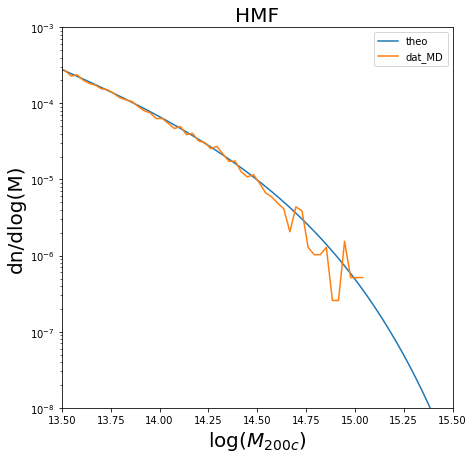

In [13]:
f = plt.figure(figsize=(7,7))
ax = f.add_subplot(111)

ax.semilogy(x_hmf_M200c,y_hmf_M200c, label='theo')

x = dat_MD[['M200c']][(dat_MD['upId']==-1) & (dat_MD['M200c']>=10**13.5)]

matt.histplot(np.log10(x.values), 
          n=50, label='dat_MD', log=1, box=True, ax=ax, func=lambda x:8*x)
    
ax.set_title('HMF', fontsize=20)
ax.set_xlabel(r'$\log(M_{200c}$)', fontsize=20)
ax.set_ylabel(r'dn/dlog(M)', fontsize=20)
ax.legend()

ax.set_xlim(13.5,15.5)
ax.set_ylim(10**-8,10**-3)

# Show Clusters

In [6]:
hosts_MD = dat_MD[(dat_MD['pId']==-1) & 
                  (np.log10(dat_MD['M200c'])>14)
                 ]

/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


host: 11824560713.0
# kids: 64


kids_out: 33
non_in: 1


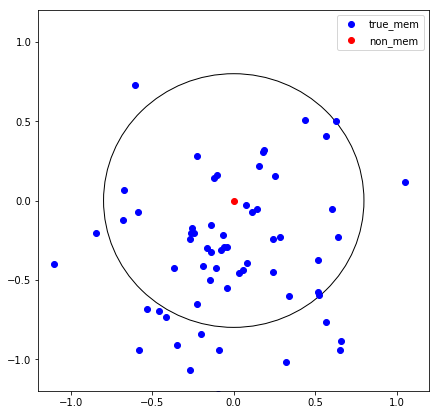

In [8]:
# Get host info
host_MD = hosts_MD.sample().iloc[0]
print('host: ' + str(host_MD['rockstarId']))

host_UM = dat_UM[host_MD['rockstarId']==dat_UM['id']].iloc[0]

radius = host_MD['Rs']/1000.

# Get kid info
kids = dat_UM[dat_UM['upid']==host_UM['id']]
print('# kids: ' + str(len(kids)))

kid_pos = kids[['x','y','z']] - host_UM[['x','y','z']]

# Get non-members
non_mem = dat_UM[
    (dat_UM['upid']==-1) &
    (dat_UM['x'] > (host_UM['x'] - 1.5*radius)) & 
    (dat_UM['x'] < (host_UM['x'] + 1.5*radius))&
    (dat_UM['y'] > (host_UM['y'] - 1.5*radius)) & 
    (dat_UM['y'] < (host_UM['y'] + 1.5*radius))&
    (dat_UM['z'] > (host_UM['z'] - 1.5*radius)) & 
    (dat_UM['z'] < (host_UM['z'] + 1.5*radius))
]
non_mem_pos = non_mem[['x','y','z']] - host_UM[['x','y','z']]


# Plot
f = plt.figure(figsize=[7,7])
ax = f.add_subplot(111)

circle = plt.Circle((0, 0), radius = radius, edgecolor='k', facecolor='none')
ax.add_artist(circle)
ax.plot(kid_pos['x'],kid_pos['y'],'o',c='b',label='true_mem')
ax.plot(non_mem_pos['x'],non_mem_pos['y'],'o',c='r',label='non_mem')

ax.set_xlim(-1.5*radius, 1.5*radius)
ax.set_ylim(-1.5*radius, 1.5*radius)
ax.legend()

# Stats
kids_out = np.sum((kid_pos['x']**2 + kid_pos['y']**2 + kid_pos['z']**2) > radius**2)
non_in = np.sum((non_mem_pos['x']**2 + non_mem_pos['y']**2 + non_mem_pos['z']**2) < radius**2)
print('\n')
print('kids_out: ' +str(kids_out))
print('non_in: ' + str(non_in))

In [65]:
dat_UM.iloc[1]['x']

3.7195727825164795

# Cosmology

In [98]:
import scipy.integrate as integrate
import scipy.interpolate as interpolate

import time

In [99]:
cosmo = {'H_0': 100, # [km/s/(Mpc/h)]
         'Omega_m': 0.307115,
         'Omega_l': 0.692885,
         'c': 299792.458 # [km/s]
         }

Text(0,0.5,'H')

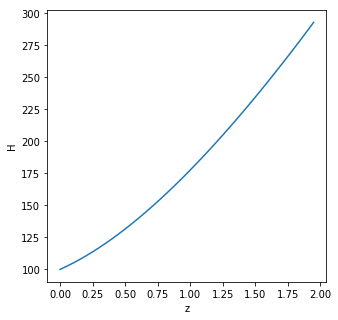

In [100]:
def H_from_z(z, cosmo):
    H = cosmo['H_0'] * (cosmo['Omega_m']*(1 + z)**3 + cosmo['Omega_l'])**0.5
    return H

samp = np.arange(0,2,0.05)

f = plt.figure(figsize=(5,5))
plt.plot(samp,H_from_z(samp, cosmo))
plt.xlabel('z')
plt.ylabel('H')

normal: 0.003621339797973633
interp: 0.0068511962890625
numpy: 9.822845458984375e-05


Text(0,0.5,'H')

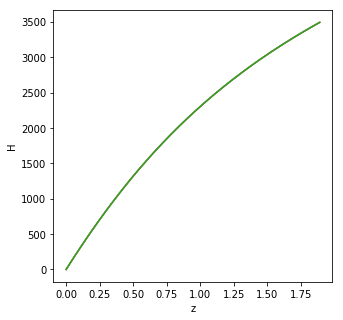

In [54]:
def d_from_z(z, cosmo):
    d = integrate.quad(lambda x: cosmo['c']/H_from_z(x, cosmo), 0, z)
    return d[0]

samp = np.arange(0,2,0.01)
test_samp = np.arange(0.00005,1.9,0.01)

t0 = time.time()
d_norm = [d_from_z(i, cosmo) for i in test_samp]
print('normal: ' + str(time.time()-t0))

d = [d_from_z(i, cosmo) for i in samp]
d_from_z_interp = interpolate.interp1d(samp, d)

t0 = time.time()
d_interp = [d_from_z_interp(i) for i in test_samp]
print('interp: ' + str(time.time()-t0))

def d_from_z_nump(z):
    d_nump = np.interp(z, samp, d)
    return d_nump

t0 = time.time()
d_nump = d_from_z_nump(test_samp)
print('numpy: ' + str(time.time()-t0))

f = plt.figure(figsize=(5,5))



plt.plot(test_samp, d_norm)
plt.plot(test_samp, d_interp)
plt.plot(test_samp, d_nump)
plt.xlabel('z')
plt.ylabel('H')

## Numpy interpolator is a factor of 10 faster than other methods

In [55]:
dat_UM.columns

Index(['x', 'y', 'z', 'vx', 'vy', 'vz', 'upid', 'id', 'mvir', 'mpeak',
       'obs_sm', 'obs_sfr'],
      dtype='object')

# KD Tree

In [6]:
from scipy.spatial import KDTree

In [7]:
kids = dat_UM[dat_UM['upid']!=-1]
hosts = dat_UM[dat_UM['upid']==-1]

In [12]:
tree = KDTree([[0,0,1],[0,0,1]], leafsize=50)

In [13]:
y = tree.query_ball_point(hosts[['x','y']].head(10),100)

ValueError: Searching for a 2-dimensional point in a 3-dimensional KDTree

In [11]:
len(y[0])

871

In [57]:
hosts.index.to_series()

0                  0
17                17
25                25
29                29
35                35
39                39
42                42
44                44
47                47
54                54
56                56
59                59
62                62
67                67
69                69
75                75
83                83
86                86
88                88
93                93
95                95
99                99
100              100
103              103
106              106
109              109
114              114
118              118
122              122
124              124
              ...   
24486883    24486883
24486884    24486884
24486885    24486885
24486891    24486891
24486897    24486897
24486900    24486900
24486903    24486903
24486907    24486907
24486908    24486908
24486915    24486915
24486925    24486925
24486926    24486926
24486934    24486934
24486943    24486943
24486948    24486948
24486950    24486950
24486960    2

In [83]:
in_ball=0
for i,row in kids[['x','y']].head(100000).iterrows():
    if ((row['x']-500)**2 + (row['y']-500)**2 < 500**2):
        in_ball +=1
print(in_ball)

467


In [35]:
w = kids['x'].head(40)+kids['y'].head(40)
w.loc[[3,16,7,60]]

/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


3     20.080687
16    19.707470
7     19.386606
60          NaN
dtype: float32

In [83]:
[x in [40,45] for x in dat_UM.iloc[40:50].index.to_series()]

[True, False, False, False, False, True, False, False, False, False]

# Rotations

In [5]:

th = np.pi*np.random.random()

m1 = np.array([[np.cos(th),-np.sin(th)],[np.sin(th),np.cos(th)]])
m2 = 4*np.array([[1],[0]])

np.matmul(m1,m2)

array([[-3.44027599],
       [ 2.04071093]])

In [23]:
dat_MD.head(5)[['x','y','z']]

,x,y,z
0,-11.717397,1.728489,11.301684
1,-9.712948,-5.744850,9.490162
2,-9.956891,-7.501455,7.641367
3,-10.747159,-9.488186,9.523682
4,-19.275559,-17.587923,15.850690


In [34]:
th_x, th_y, th_z = 2*np.pi*np.random.random(3)

# th_x = np.pi

R_x = np.array([[1,0,0],
                [0, np.cos(th_x), -np.sin(th_x)], 
                [0, np.sin(th_x), np.cos(th_x)]]
              )

R_y = np.array([[np.cos(th_y), 0, np.sin(th_y)],
                [0, 1, 0],
                [-np.sin(th_y), 0, np.cos(th_y)]]
              )

R_z = np.array([[np.cos(th_z), -np.sin(th_z), 0],
                [np.sin(th_z), np.cos(th_z), 0],
                [0,0,1]]
              )
R = np.matmul(R_z, R_y, R_x)



dat_MD.loc[0:5,['x','y','z']] = np.matmul(dat_MD.loc[0:5,['x','y','z']].values, R.T)

In [46]:
pd.DataFrame(, columns=['x','y','z'])

,x,y,z
0,11.352279,-0.516439,11.784404
1,4.002012,-2.626083,13.946162
2,1.687031,-1.641814,14.431229
3,1.483578,-3.112528,16.862348
4,1.526903,-4.851591,30.104107
5,17.480813,14.432387,14.916863


In [48]:
import time

t0 = time.time()
gal_pos = np.matmul(dat_MD[['x','y','z']], R.T)
t1 = time.time()
gal_pos = pd.DataFrame(gal_pos, columns=['x','y','z'])
t2 = time.time()

print(t1-t0)
print(t2-t1)

0.16823577880859375
0.0007598400115966797


# Load/Save catalog

In [ ]:
import pickle

In [26]:
class Cluster:
    
    def __init__(self, prop=None, gal=None):
        self.prop = prop
        self.gal = gal

class Catalog:
    def __getitem__(self, key):
        return Cluster(prop = self.prop.iloc[key],
                       gal = self.gal[key])
    def __len__(self):
        return len(self.prop)
    
    def __init__(self, prop=None, gal=None):
        self.prop = prop # Properties of host clusters. (# clusters) x (# of properties)
        self.gal = gal # Cluster members. Position, velocities, etc.
    
    def save(self,filename):
        with open(filename, 'wb') as out_file:
            pickle.dump(self, out_file)
    def load(self, filename):
        with open(filename, 'rb') as in_file:
            new_cat = pickle.load(in_file)
        
        self.prop = new_cat.prop
        self.gal = new_cat.gal

In [27]:
c = Catalog(prop = pd.DataFrame(np.random.rand(100,len(dat_MD.columns)),
                                columns=dat_MD.columns
                               ),
            gal = [np.random.rand(5,np.random.randint(15)) for i in range(100)]
           )

In [28]:
file_name = os.path.join(wdir,'data_raw','catalog','temp.p')

c.save(file_name)

In [29]:
c.prop.head()

,row_id,rockstarId,upId,pId,descId,breadthFirstId,M200b,Rvir,x,y,...,vx,vy,vz,M500c,Rs,Macc,Vacc,Mvir,M200c,scale
0,0.081327,0.827463,0.517041,0.783035,0.242950,0.005151,0.059740,0.510258,0.447961,0.118091,...,0.518459,0.759606,0.773318,0.556385,0.712711,0.875113,0.881270,0.528273,0.040974,0.143970
1,0.371553,0.666226,0.103578,0.192403,0.043131,0.962065,0.397233,0.868677,0.789545,0.865311,...,0.490728,0.959442,0.832670,0.384788,0.983948,0.705448,0.443895,0.311246,0.440022,0.109309
2,0.422287,0.866850,0.272102,0.665185,0.691286,0.224001,0.305792,0.992446,0.491964,0.140620,...,0.949099,0.396328,0.157017,0.027252,0.099027,0.541977,0.105500,0.260430,0.105840,0.760412
3,0.386519,0.220909,0.206619,0.632416,0.754664,0.658839,0.369257,0.142260,0.706999,0.946186,...,0.935309,0.489431,0.841294,0.662617,0.496387,0.122466,0.911771,0.441999,0.681289,0.557740
4,0.473522,0.177748,0.145955,0.624807,0.447260,0.704414,0.644913,0.272200,0.472394,0.747422,...,0.811833,0.002548,0.214302,0.707073,0.077141,0.731867,0.814034,0.936873,0.194387,0.969809


In [30]:
c = Catalog()
c.load(file_name)

In [33]:
c.gal

[array([[0.46430587, 0.4716896 ],
        [0.12582955, 0.15573872],
        [0.93246209, 0.90815433],
        [0.52215271, 0.10213539],
        [0.66252004, 0.90061969]]),
 array([[0.41557278, 0.8173551 , 0.06905902, 0.11268233, 0.71857878,
         0.73231955, 0.99180401, 0.79878689, 0.54294509, 0.49273659,
         0.53542201, 0.7700309 ],
        [0.86077947, 0.86817212, 0.09083004, 0.98759154, 0.82950877,
         0.82474322, 0.91063983, 0.66444724, 0.71418192, 0.40586528,
         0.98706837, 0.04112764],
        [0.0303127 , 0.47878925, 0.79800297, 0.17411533, 0.1350514 ,
         0.19228943, 0.58539521, 0.91978918, 0.71443392, 0.28963039,
         0.63082044, 0.28927007],
        [0.11950601, 0.09098574, 0.98676758, 0.025804  , 0.21746572,
         0.04974628, 0.20674756, 0.74912753, 0.68862535, 0.24840318,
         0.52530351, 0.37581537],
        [0.62074571, 0.57516691, 0.76128065, 0.63485085, 0.57237388,
         0.69240922, 0.17357863, 0.26924819, 0.05595954, 0.23905739,
  

In [18]:
p = pd.DataFrame.from_csv(os.path.join(wdir,'data_raw','catalog','Rockstar_UM_z=0.117_pure_prop.csv'))
g = np.load(os.path.join(wdir,'data_raw','catalog','Rockstar_UM_z=0.117_pure_gal.npy'))

/home/mho1/.conda/envs/jupy/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [22]:
c = Catalog(prop=p,
            gal=g
           )

In [24]:
with open(os.path.join(wdir,'data_raw','catalog','Rockstar_UM_z=0.117_pure.p'),'wb') as out_file:
    pickle.dump(c,out_file)

# Catalog characteristics

In [6]:
pure_cat = Catalog().load(os.path.join(wdir,'data_mocks','Rockstar_UM_z=0.117_pure.p'))

contam_cat = Catalog().load(os.path.join(wdir,'data_mocks','Rockstar_UM_z=0.117_contam.p'))

In [8]:
hmf_Macc = np.loadtxt(os.path.join(wdir, 'data_raw', 'dn_dlogm_MDPL2_z=0.117_Macc.txt'))

x_hmf_Macc, y_hmf_Macc = zip(*hmf_Macc)

x_hmf_Macc = np.log10(x_hmf_Macc)

In [9]:
hmf_M200c = np.loadtxt(os.path.join(wdir, 'data_raw', 'dn_dm_MDPL2_z=0.117_M200c.txt'))

x_hmf_M200c, y_hmf_M200c = hmf_M200c

y_hmf_M200c = x_hmf_M200c*y_hmf_M200c*np.log(10)
x_hmf_M200c = np.log10(x_hmf_M200c)

In [8]:
dat_mich = np.load(os.path.join(wdir,'data_mocks','UM_z=0.117_large_reduced.npy'))
print(sys.getsizeof(dat_mich)/10.**9, ' GB')
print(dat_mich.dtype.names)

0.88386974  GB
('Mtot', 'hostid', 'R200', 'rotation', 'fold', 'Ngal', 'vlos', 'sigmav', 'Rproj', 'xyproj', 'name', 'truememb', 'intest', 'intrain', 'redshift', 'Rs')


In [9]:
print('pure_len: ', len(pure_cat))
print('contam_len: ', len(contam_cat))
print('mich_len: ', len(dat_mich))

pure_len:  711420
contam_len:  902935
mich_len:  43183


(1e-08, 0.001)

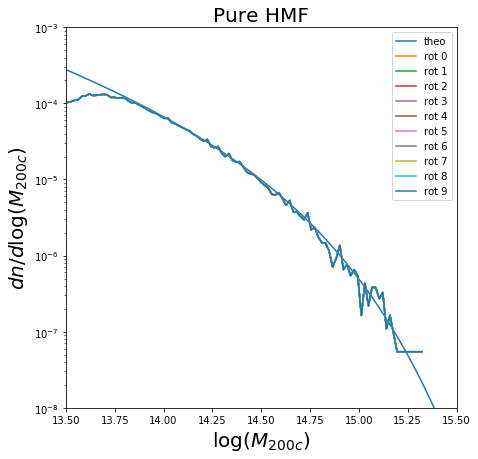

In [10]:
f = plt.figure(figsize=(7,7))
ax = f.add_subplot(111)

ax.plot(x_hmf_M200c,y_hmf_M200c, label='theo')

for r in range(int(pure_cat.prop['rotation'].max()+1)):
    
    matt.histplot(np.log10(pure_cat.prop['M200c'][pure_cat.prop['rotation']==r].values), 
              n=100, label='rot ' + str(r), log=1, box=True, ax=ax)
    
ax.set_title('Pure HMF', fontsize=20)
ax.set_xlabel(r'$\log(M_{200c}$)', fontsize=20)
ax.set_ylabel(r'$dn/d\log(M_{200c})$', fontsize=20)
ax.legend()

ax.set_xlim(13.5,15.5)
ax.set_ylim(10**-8,10**-3)

(1e-08, 0.001)

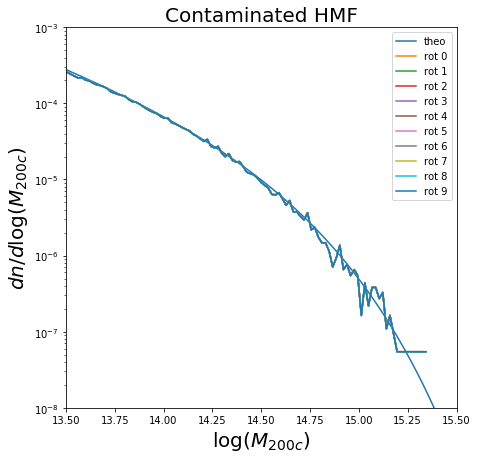

In [11]:
f = plt.figure(figsize=(7,7))
ax = f.add_subplot(111)

ax.plot(x_hmf_M200c,y_hmf_M200c, label='theo')

for r in range(int(contam_cat.prop['rotation'].max()+1)):
    
    matt.histplot(np.log10(contam_cat.prop['M200c'][contam_cat.prop['rotation']==r].values), 
              n=100, label='rot ' + str(r), log=1, box=True, ax=ax)
    
ax.set_title('Contaminated HMF', fontsize=20)
ax.set_xlabel(r'$\log(M_{200c}$)', fontsize=20)
ax.set_ylabel(r'$dn/d\log(M_{200c})$', fontsize=20)
ax.legend()

ax.set_xlim(13.5,15.5)
ax.set_ylim(10**-8,10**-3)

(1e-08, 0.001)

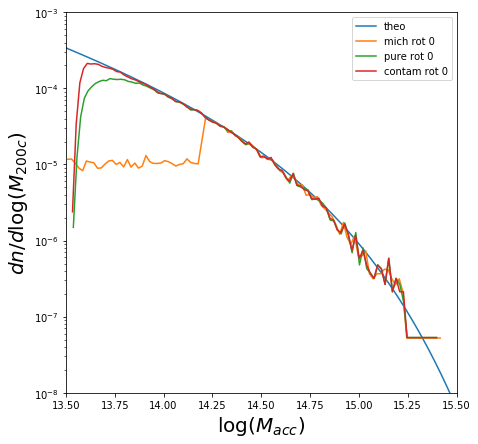

In [12]:

rot = 0#np.random.choice(c.prop['rotation'])

f = plt.figure(figsize=(7,7))
ax = f.add_subplot(111)

ax.plot(x_hmf_Macc, y_hmf_Macc, label='theo')


matt.histplot(np.log10(dat_mich['Mtot'][dat_mich['rotation']==rot]), 
              n=100, label='mich rot '+ str(rot),log=1, box=True, ax=ax)

matt.histplot(np.log10(pure_cat.prop['Macc'][pure_cat.prop['rotation']==rot]), 
              n=100, label='pure rot ' + str(rot), log=1, box=True, ax=ax)
matt.histplot(np.log10(contam_cat.prop['Macc'][contam_cat.prop['rotation']==rot]), 
              n=100, label='contam rot ' + str(rot), log=1, box=True, ax=ax)

ax.set_xlabel(r'$\log(M_{acc}$)', fontsize=20)
ax.set_ylabel(r'$dn/d\log(M_{200c})$', fontsize=20)
ax.legend()

ax.set_xlim(13.5,15.5)
ax.set_ylim(10**-8,10**-3)

In [ ]:
# pure_cat.prop['sigv'] = [np.std(x['vlos']) for x in pure_cat.gal]
# contam_cat.prop['sigv'] = [np.std(x['vlos']) for x in contam_cat.gal]

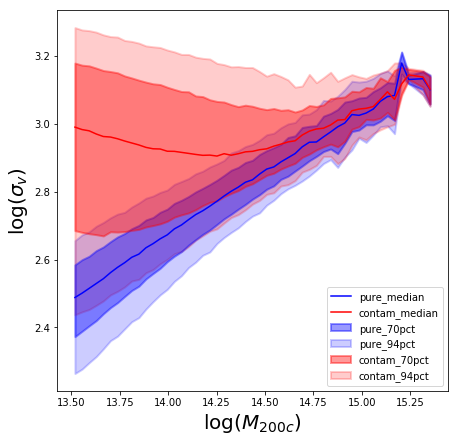

In [12]:

f = plt.figure(figsize=(7,7))
ax = f.add_subplot(111)

matt.binnedplot(np.log10(pure_cat.prop['M200c']),np.log10(pure_cat.prop['sigv']), 
                percentiles=[35,47],
                n=50, label='pure_',ax=ax, log=0, c='b', names=True)
matt.binnedplot(np.log10(contam_cat.prop['M200c']),np.log10(contam_cat.prop['sigv']), 
                percentiles=[35,47],
                n=50, label='contam_',ax=ax, log=0, c='r', names=True)

# ax.set_xlim(14,15.3)
# ax.set_ylim(2.3,3.3)

plt.xlabel(r'$\log(M_{200c})$', fontsize=20)
plt.ylabel(r'$\log(\sigma_v)$', fontsize=20)
ax.legend(loc=4)

## Random Cluster

In [13]:
rcut = contam_cat.par['aperture'] #Mpc/h
vcut = contam_cat.par['vcut'] #km/s

host id: 11927214663.0
rotation: 6.0
log(M_200c): 14.144947633670373


TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

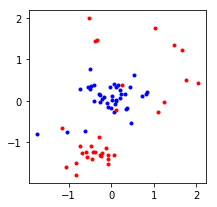

In [14]:
i = np.random.randint(0, len(contam_cat))
# i = np.argwhere(dat_MD['hostid']==3339815782)[0][0]

print('host id: ' + str(contam_cat.prop['rockstarId'][i]))
print('rotation: ' + str(contam_cat.prop['rotation'][i]))
print('log(M_200c): ' + str(np.log10(contam_cat.prop['M200c'][i])))

f = plt.figure(figsize=[7,7])
gs = mpl.gridspec.GridSpec(2,2)


ax1 = f.add_subplot(gs[0,0])

x = contam_cat.gal[i]['xproj']
y = contam_cat.gal[i]['yproj']

ax1.plot(x[contam_cat.gal[i]['true_memb']==1],
         y[contam_cat.gal[i]['true_memb']==1],
         '.', c='b')
ax1.plot(x[contam_cat.gal[i]['true_memb']!=1],
         y[contam_cat.gal[i]['true_memb']!=1],
         '.', c='r')
circle = plt.Circle((0, 0), radius = rcut, edgecolor='k', facecolor='none')
ax1.add_artist(circle)

ax1.set_xlim(-rcut,rcut)
ax1.set_ylim(-rcut,rcut)
ax1.ticklabel_format(style='sci',axis='both', scilimits=(-1,1))
ax1.set_xlabel('$x_{proj}$', fontsize=14)
ax1.set_ylabel('$y_{proj}$', fontsize=14)


ax2 = f.add_subplot(gs[0,1])
x = np.sqrt(contam_cat.gal[i]['xproj']**2 + contam_cat.gal[i]['yproj']**2)
y = contam_cat.gal[i]['vlos']

# ax2.plot(np.arange(0,6./5*rcut,rcut/5.),[0]*6, c='k', linestyle='dashed')

ax2.plot(x[contam_cat.gal[i]['true_memb']==1],
         y[contam_cat.gal[i]['true_memb']==1],
         '.', c='b',label='true')
ax2.plot(x[contam_cat.gal[i]['true_memb']!=1],
         y[contam_cat.gal[i]['true_memb']!=1],
         '.', c='r',label='interloper')
plt.legend()

ax2.set_xlim(0,rcut)
ax2.set_ylim(-vcut,vcut)
ax2.ticklabel_format(style='sci',axis='both', scilimits=(-1,1))
ax2.set_xlabel('$R_{proj}$', fontsize=14)
ax2.set_ylabel('$v_{los}$', fontsize=14)



ax3 = f.add_subplot(gs[1,:])
kde = gaussian_kde(contam_cat.gal[i]['vlos'])
pos = np.arange(-vcut,vcut, vcut/(48/2.))
y = kde(pos)
y /= np.sum(y)

ax3.bar(pos, y, width=50)

ax3.ticklabel_format(style='sci',axis='both', scilimits=(-1,1))
ax3.set_xlabel('$v_{los}$', fontsize=14)

f.suptitle('# ' + str(contam_cat.prop['rockstarId'][i]) + 
           ' ; $\log(M_{200c}) = $ ' + str(np.log10(contam_cat.prop['M200c'][i])), 
           y=1.03,fontsize=14)

plt.tight_layout()

# f.savefig(os.path.join(img_savedir,'MD_cluster.pdf'))

# Folds

In [6]:
# pure_cat = Catalog().load(os.path.join(wdir,'data_mocks','Rockstar_UM_z=0.117_pure.p'))

contam_cat = Catalog().load(os.path.join(wdir,'data_mocks','Rockstar_UM_z=0.117_contam.p'))

Loading catalog from: /home/mho1/scratch/halo_cnn/data_mocks/Rockstar_UM_z=0.117_contam.p


In [8]:
hmf_M200c = np.loadtxt(os.path.join(wdir, 'data_raw', 'dn_dm_MDPL2_z=0.117_M200c.txt'))

x_hmf_M200c, y_hmf_M200c = hmf_M200c

y_hmf_M200c = x_hmf_M200c*y_hmf_M200c*np.log(10)
x_hmf_M200c = np.log10(x_hmf_M200c)

In [9]:
cat = contam_cat

In [20]:
Nfolds=10

m_bin=0.01


fold_ind = pd.Series(np.random.randint(0,Nfolds,len(cat.prop['rockstarId'].unique())), 
                  index = cat.prop['rockstarId'].unique())

fold = fold_ind[cat.prop['rockstarId']]

fold_assign = pd.DataFrame(np.zeros(shape=(len(cat),Nfolds)), 
                           index = cat.prop.index)


for i in range(Nfolds):
    print('fold:',i)
    
    fold_assign.loc[fold_assign.index[fold==i],i] = 2
    
    log_m = np.log10(cat.prop.loc[fold_assign.index[fold!=i],'M200c'])

    bin_edges = np.arange(log_m.min() * 0.9999, (log_m.max() + m_bin)*1.0001, m_bin)
    
    n_per_bin = int(len(log_m)/(10*len(bin_edges)))
    
    for j in range(len(bin_edges)):
        bin_ind = log_m.index[ (log_m >= bin_edges[j])&(log_m < bin_edges[j]+m_bin) ]
        
        if len(bin_ind) <= n_per_bin:
            fold_assign.loc[bin_ind,i] = 1
            
        else:
            fold_assign.loc[np.random.choice(bin_ind, n_per_bin), i] = 1


fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
fold: 5
fold: 6
fold: 7
fold: 8
fold: 9


len_train: 52203
len_test: 88951


(1e-08, 0.001)

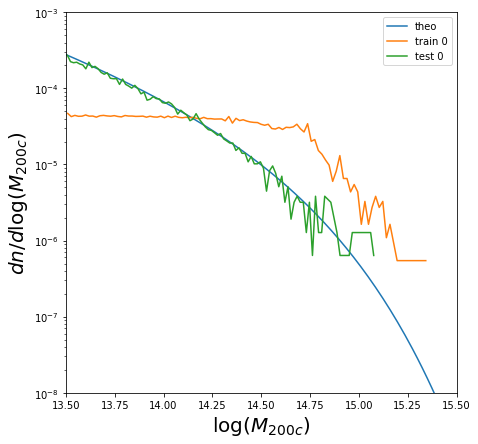

In [21]:
fold=np.random.randint(0,Nfolds)

print('len_train:',np.sum(fold_assign[fold]==1))
print('len_test:',np.sum(fold_assign[fold]==2))

f = plt.figure(figsize=(7,7))
ax = f.add_subplot(111)

ax.plot(x_hmf_M200c, y_hmf_M200c, label='theo')


matt.histplot(np.log10(cat.prop['M200c'][fold_assign[fold]==1]), 
              n=100, label='train ' + str(fold), log=1, box=True, ax=ax)
matt.histplot(np.log10(cat.prop['M200c'][fold_assign[fold]==2]), 
              n=100, label='test ' + str(fold), log=1, box=True, ax=ax)

ax.set_xlabel(r'$\log(M_{200c}$)', fontsize=20)
ax.set_ylabel(r'$dn/d\log(M_{200c})$', fontsize=20)
ax.legend()

ax.set_xlim(13.5,15.5)
ax.set_ylim(10**-8,10**-3)

In [11]:
log_m = np.log10(pure_cat.prop['M200c'])

log_m_min, log_m_max = log_m.min(), log_m.max()

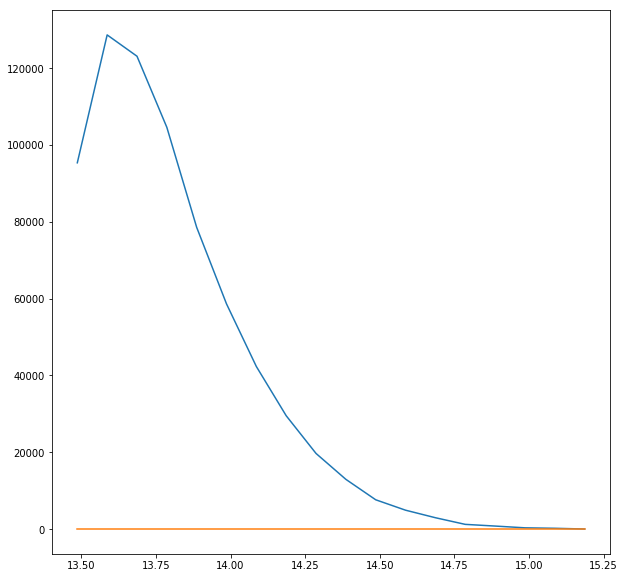

In [66]:
bin_edges = np.arange(log_m_min * 0.999, log_m_max*1.001, 0.1)

num_per_bin = 

len_intrvl = []
for i in range(len(intrvls)-1):
    log_m.index[(log_m>=intrvls[i]) & (log_m<intrvls[i+1])]
    
plt.plot(intrvls[:-1], len_intrvl)
plt.plot(intrvls[:-1], [0]*len(len_intrvl))

In [65]:
np.mean(len_intrvl)

7186.060606060606

In [34]:
i=100

mesh = np.mgrid[-pure_cat.par['vcut'] : pure_cat.par['vcut'] : 48*1j]

sample = np.vstack([mesh.ravel()]) # Velocities at fixed intervals. Used to sample velocity pdfs

# initialize a gaussian kde from galaxy velocities
kde = gaussian_kde(pure_cat.gal[i]['vlos'])

# sample kde at fixed intervals
kdeval = np.reshape(kde(sample).T, mesh.shape)

# normalize input
kdeval /= kdeval.sum()

In [39]:
np.array([kdeval]*100).shape

(100, 48)

# Scratch

In [46]:
host_pos = dat_MD.iloc[7][['x','y','z']]

np.sqrt(np.sum((dat_MD.iloc[[4,5,6]][['x','y','z']] - host_pos)**2,axis=1)).idxmin()

6

In [64]:
dat_MD.loc[4:6]

,row_id,rockstarId,upId,pId,descId,breadthFirstId,M200b,Rvir,x,y,...,vx,vy,vz,M500c,Rs,Macc,Vacc,Mvir,M200c,scale
4,5,11821542837,-1,-1,11972170721,6628740257,1.174200e+11,102.072,2.54390,1.23761,...,-403.86,-100.01,83.13,3.010800e+10,34.640,1.114000e+11,73.04,1.114000e+11,6.623800e+10,0.8951
5,6,11821539417,-1,-1,11972167296,6092917351,1.234400e+11,104.759,7.76026,5.01127,...,-435.18,-19.32,142.21,7.527100e+10,11.495,1.204300e+11,87.78,1.204300e+11,1.038700e+11,0.8951
6,7,11821534927,-1,-1,11972162822,4395842099,3.929100e+11,153.158,14.02830,6.33010,...,-369.72,-111.84,242.74,2.709700e+11,10.872,3.763500e+11,137.21,3.763500e+11,3.296800e+11,0.8951


In [60]:

angle_list[0:3]

[(0, 0, 0), (1.5707963267948966, 0, 0), (0, 1.5707963267948966, 0)]

In [49]:
th = None

a,b,c = np.random.random(3) if th==None else th

In [66]:
np.random.random(3) is None

False

In [6]:
pillar_ind = np.random.randint(0,len(dat_MD),1000)
true_memb = np.random.randint(0,len(dat_MD),1000)

In [7]:
[i for i in true_memb if i not in pillar_ind]

[1174822,
 3356131,
 2711668,
 3063547,
 2153460,
 3222173,
 1982275,
 4382662,
 4506260,
 4076137,
 4009190,
 4549183,
 1550693,
 2881937,
 3611584,
 2152235,
 4656914,
 4470798,
 1537537,
 3067805,
 1647420,
 4437902,
 463962,
 3587966,
 1601902,
 178464,
 3489712,
 116973,
 3090421,
 2652872,
 2415620,
 3600306,
 285281,
 2131797,
 2737875,
 1535599,
 915602,
 1843887,
 1582929,
 3090644,
 3064791,
 4073488,
 1529063,
 4160669,
 4172923,
 1136944,
 1545193,
 3718321,
 1533147,
 1332051,
 380006,
 3797227,
 3963668,
 4710185,
 1972558,
 477288,
 4070649,
 2872063,
 2171457,
 3958614,
 3053258,
 3036784,
 1643930,
 1027403,
 1619625,
 4705177,
 799847,
 705299,
 832188,
 3589129,
 2453836,
 1766714,
 1296545,
 2204928,
 1445158,
 1596037,
 3044156,
 2329224,
 1018905,
 3600404,
 1931167,
 3088284,
 3357687,
 4148467,
 2837434,
 121113,
 1325677,
 4236989,
 428074,
 4480217,
 2800696,
 1813092,
 4190276,
 2324345,
 2391928,
 931442,
 2711633,
 1398775,
 2662503,
 2864582,
 1890270,
 40

In [67]:


x = 'd'*(10**9)
t0 = time.time()
y = [None]*100
y[3] = x
t1 = time.time()
y = [None]*100
y.append(x)
t2 = time.time()
print(t1-t0)
print(t2-t0)

0.10101199150085449
0.10110712051391602


gal = np.array(contam_cat.gal)

In [16]:
x = np.array([1,4,5,6])
x[1:4] = [4,6,7]

In [18]:
np.ndarray(shape=(48,))

array([ 5.69788486e-315, -4.46794005e-009, -1.26285260e+018,
        1.24477644e+078, -3.69656133e+000,  5.40437492e-315,
        1.44459542e-008, -4.48844484e+019,  1.07927129e+082,
       -1.14536777e-001,  5.72447764e-315,  6.03442149e-007,
        4.81710377e+024,  1.33147934e+084, -1.46672459e-006,
        3.74541436e-314, -1.50196576e-002,  1.83321183e+025,
        3.73380276e+082, -1.27625327e-007,  2.66918933e-314,
       -1.39067376e-008,  2.53773380e+025,  1.17280202e+076,
       -1.40711292e-012,  2.68023665e-314, -3.52925569e-009,
        3.69093298e+019,  1.20369586e+087,  1.97976495e-010,
        2.68881921e-314, -1.76822064e-007, -9.31566592e+015,
        3.60936118e+087, -3.87285864e-007,  2.67965157e-314,
        1.12166901e-012,  1.49233332e+018,  2.35484723e+085,
        6.02382409e-009,  2.67569148e-314, -5.22643094e-007,
        3.05196884e+018,  1.53480695e+081, -6.40937243e-004,
        5.72688877e-315,  1.09368450e+000,  8.33220867e+024])

In [71]:
pad_regions = []
pad_directions = (None, False, True)

for i in pad_directions:
    for j in pad_directions:
        for k in pad_directions:
            pad_regions.append((i,j,k))

            
pad_regions

[(None, None, None),
 (None, None, False),
 (None, None, True),
 (None, False, None),
 (None, False, False),
 (None, False, True),
 (None, True, None),
 (None, True, False),
 (None, True, True),
 (False, None, None),
 (False, None, False),
 (False, None, True),
 (False, False, None),
 (False, False, False),
 (False, False, True),
 (False, True, None),
 (False, True, False),
 (False, True, True),
 (True, None, None),
 (True, None, False),
 (True, None, True),
 (True, False, None),
 (True, False, False),
 (True, False, True),
 (True, True, None),
 (True, True, False),
 (True, True, True)]

In [38]:
pad_gal_data = pd.DataFrame(np.zeros(shape=(100, dat_UM.shape[1])), 
                            columns = dat_UM.columns)

pad_gal_data.values[0:5,:] = dat_UM.iloc[5:10].values
# print(pad_gal_data.head(10))
# print(dat_UM.head(5))
pad_gal_data

,x,y,z,vx,vy,vz,upid,id,mvir,mpeak,obs_sm,obs_sfr
0,3.700108,16.225718,91.832970,-658.988281,-31.404678,151.654938,1.182156e+10,3.500001e+16,3.324754e+10,2.980700e+11,2.395962e+10,0.068386
1,3.471246,16.180105,91.995720,-532.088745,-598.383484,284.099426,1.182156e+10,2.500001e+16,1.520150e+11,1.190800e+12,5.593840e+10,0.401510
2,2.977862,16.408745,91.987038,-236.450409,79.963394,924.542480,1.182156e+10,6.800000e+16,5.085003e+09,6.623800e+10,3.207689e+09,0.003328
3,3.137563,16.505594,91.956978,-196.435181,-270.985626,-21.743271,1.182156e+10,5.400000e+16,1.033524e+11,2.089500e+12,3.278440e+10,2.158500
4,4.140018,16.731819,92.002434,-575.110413,-390.126129,293.410706,1.182156e+10,4.800000e+16,7.068176e+09,1.911900e+11,6.648070e+09,0.002949
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000


In [13]:
dat_MD.iloc[1].index

Index(['row_id', 'rockstarId', 'upId', 'pId', 'descId', 'breadthFirstId',
       'M200b', 'Rvir', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'M500c', 'Rs', 'Macc',
       'Vacc', 'Mvir', 'M200c', 'scale'],
      dtype='object')

In [95]:
dat_UM.shape
x = pd.DataFrame(np.zeros(shape=(13,dat_UM.shape[1])), columns = dat_UM.columns)
x.iloc[0] = dat_UM.iloc[0]
y = x

y.append(x)

,x,y,z,vx,vy,vz,upid,id,mvir,mpeak,obs_sm,obs_sfr
0,3.40585,16.63718,91.84906,-208.309998,-186.809998,242.970001,-1.0,1.182156e+10,1.726200e+14,1.728100e+14,1.194319e+12,1.024768
1,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
2,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
3,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
4,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
5,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
6,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
7,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
8,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
9,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000


In [9]:
dat_MD.sort_values(by=['rockstarId'], axis=0).head(10)

,Unnamed: 0.1,row_id,rockstarId,upId,pId,descId,breadthFirstId,M200b,Rvir,x,...,vx,vy,vz,M500c,Rs,Macc,Vacc,Mvir,M200c,scale
42,42,43,11821523287,-1,-1,11972151404,4185086937,4.501200e+11,158.102,29.15900,...,83.77,6.57,-414.23,3.025900e+11,9.002,4.139900e+11,141.36,4.139900e+11,3.733400e+11,0.8951
654386,654386,654387,11821523288,11830111836,11830111836,11972151405,6773350480,1.083900e+11,100.673,30.06720,...,-563.00,94.89,-88.72,9.935700e+10,5.067,1.580700e+11,100.13,1.068800e+11,1.038700e+11,0.8951
2617569,2617569,2617570,11821523289,-1,-1,11972151406,4867230843,2.529100e+11,130.317,48.48210,...,63.33,-129.05,-229.49,1.595700e+11,8.713,2.318300e+11,119.68,2.318300e+11,2.017200e+11,0.8951
1968660,1968660,1968661,11821523292,-1,-1,11972151409,6140198119,1.174200e+11,102.983,68.11470,...,-47.25,-81.84,50.30,7.677600e+10,13.392,1.144100e+11,83.36,1.144100e+11,9.634600e+10,0.8951
981872,981872,981873,11821523295,11821523412,11821523412,11972151412,5784653325,1.866700e+11,120.582,4.20388,...,-671.59,-8.93,-852.89,1.475300e+11,6.506,2.363500e+11,139.60,1.836600e+11,1.776400e+11,0.8951
1309030,1309030,1309031,11821523303,-1,-1,11972151420,4728946489,2.800100e+11,135.990,5.14392,...,-358.24,-313.09,-588.38,2.032300e+11,5.436,2.634500e+11,132.80,2.634500e+11,2.423700e+11,0.8951
327499,327499,327500,11821523316,11821523412,11821523412,11972151432,6003314357,1.731200e+11,115.422,4.57579,...,-157.18,328.03,-635.48,1.098900e+11,20.552,2.920500e+11,162.09,1.610800e+11,1.400000e+11,0.8951
2617839,2617839,2617840,11821523319,11821523412,11821523412,11972151435,7868188715,7.376500e+10,88.966,4.64085,...,-506.75,-273.80,-47.78,6.774300e+10,2.542,1.400000e+11,128.92,7.376500e+10,7.226000e+10,0.8951
2617841,2617841,2617842,11821523329,-1,-1,11972151445,6140198187,1.249500e+11,103.878,4.85800,...,-541.07,613.90,-713.66,9.484100e+10,5.488,1.174200e+11,104.33,1.174200e+11,1.098900e+11,0.8951
1309031,1309031,1309032,11821523333,11821523334,11821523334,11972151449,7020026982,9.183000e+10,94.648,4.94306,...,-102.89,380.13,-883.46,5.118400e+10,5.687,1.836600e+11,94.70,8.881900e+10,7.677600e+10,0.8951


In [2]:
from collections import OrderedDict

In [4]:
par = OrderedDict()

In [17]:
par1 = OrderedDict([
    ('wdir', '/home/mho1/scratch/halo_cnn/')
])
par2 = OrderedDict([
    ('model_name', 'halo_cnn1d_r')
])

In [13]:
for key in par.keys():
    print(key + ' : ' + str(par[key]))

wdir : /home/mho1/scratch/halo_cnn/
model_name : halo_cnn1d_r


In [18]:
par1.update(par2)

In [23]:
par1

OrderedDict([('wdir', '/home/mho1/scratch/halo_cnn/'),
             ('model_name', 'halo_cnn1d_r')])

In [4]:
from bs4 import BeautifulSoup

In [6]:
xml = '''<uws:job xmlns:uws="http://www.ivoa.net/xml/UWS/v1.0" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" version="1.1">
  <uws:jobId>1528838918683310284</uws:jobId>
  <uws:runId xsi:nil="true"/>
  <uws:ownerId>maho3</uws:ownerId>
  <uws:phase>PENDING</uws:phase>
  <uws:quote xsi:nil="true"/>
  <uws:creationTime>2018-06-12T23:28:38+02:00</uws:creationTime>
  <uws:startTime xsi:nil="true"/>
  <uws:endTime xsi:nil="true"/>
  <uws:executionDuration>0</uws:executionDuration>
  <uws:destruction xsi:nil="true"/>
  <uws:parameters/>
  <uws:results/>
</uws:job>
'''

In [11]:
soup = BeautifulSoup(xml,'xml')

In [15]:
soup.find('uws:jobId').getText()

'1528838918683310284'

In [40]:
host_drop = ['row_id','upId','pId','descId','breadthFirstId','scale']

dat_MD.head()[[i for i in dat_MD.columns.values if i not in host_drop]]

,rockstarId,M200b,Rvir,x,y,z,vx,vy,vz,M500c,Rs,Macc,Vacc,Mvir,M200c
0,11821536357,1.806500e+11,117.540,13.806758,-8.653011,-1.584917,-474.57,-86.47,-185.71,1.189300e+11,7.774,1.701100e+11,102.52,1.701100e+11,1.460200e+11
1,11821538117,1.746300e+11,117.540,13.727866,-1.552345,-5.152065,-542.60,-142.91,-76.36,1.219400e+11,13.374,1.701100e+11,100.19,1.701100e+11,1.550600e+11
2,11821536297,1.339800e+11,107.729,12.737955,-0.326572,-7.172156,-652.79,-187.36,-54.90,6.774300e+10,18.702,1.309700e+11,82.89,1.309700e+11,1.174200e+11
3,11821537517,1.354900e+11,106.897,15.285599,0.735671,-7.876349,-631.40,-151.32,-55.96,8.279800e+10,10.505,1.279600e+11,91.76,1.279600e+11,1.098900e+11
4,11821542837,1.174200e+11,102.072,26.513309,1.767421,-15.034870,-403.86,-100.01,83.13,3.010800e+10,34.640,1.114000e+11,73.04,1.114000e+11,6.623800e+10


In [4]:
dir_name = os.path.join(wdir,'data_query','subsets')
f1 = os.path.join(dir_name,'MDPL2_Rockstar_snap:120_x:[0,250]_1529097112172024553.csv')
f2 = os.path.join(dir_name,'MDPL2_Rockstar_snap:120_x:[250,500]_1529097114379758456.csv')
dat = pd.read_csv(f1)
print(len(dat))
dat=dat.append(pd.read_csv(f2))
print(len(dat))

9475580
18988741


In [7]:
d = {'M':[12,4,5], 'vlos':[np.array([12,34,5]),np.array([235,7])]}
print(d)
df = pd.DataFrame(data=d)

{'M': [12, 4, 5], 'vlos': [array([12, 34,  5]), array([235,   7])]}


ValueError: arrays must all be same length

In [10]:
d = dict( A = np.array([1,2]), B = np.array([1,2,3,4]) )
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))


In [4]:
x = 'm.csv'
print(x[-4:])

.csv
